# Particle Filter on Episode

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、上田が https://link.springer.com/chapter/10.1007/978-3-319-48036-7_54 で公表した「particle filter on episode」というアルゴリズムです。簡単なタスクを学習できますが、まだ弱いです。

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

## イベント、エピソードのクラス

記憶をモデル化します。行動に必要な情報は、結局のところどう動いて何を見て、どんな良いこと・悪いことがあったか、だけになります。

In [2]:
class Event:
    TIME = 0
    def __init__(self,action,reward,observation):
        self.action = action
        self.reward = reward
        self.observation = observation
        self.time = TIME
        TIME += 1
        
    def __str__(self):
        return "action:" + str(self.action) + "\t" + "reward:" + str(self.reward) + "\t" + "observation:" + str(self.observation)
        
class Episodes:   #強化学習では一つの試行をエピソードと呼ぶ。このクラスは複数のエピソードをずーっとシーケンシャルに持つので、Episodesと複数形に。
    def __init__(self):
        self.events = []
        
    def __str__(self):
        es = []
        for e in self.events:
            es.append(str(e))
        
        return "\n".join(es)

## ロボットのクラス

環境と相互作用しながら記憶を蓄積していきます。

In [3]:
class Action:
    def __init__(self,name,fw,rot):
        self.name = name
        self.fw = fw
        self.rot = rot

class Robot:
    def __init__(self):
        self.episodes = Episodes()
        
        self.actions = [Action("fw",100.0,0.0), Action("cw",0.0,-90.0), Action("ccw",0.0,90.0)]
        
    def observe(self):
        return None
    
    def __motion(self, pos, fw, rot):
        actual_fw = random.gauss(fw,fw/10)    #標準偏差にしてfwの10%だけ移動距離に雑音を入れる
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 前進時にロボットの進路が曲がる雑音。標準偏差3[deg] 
        
        px, py, pt = pos
        
        #前進させる
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        
        #回転。回転角にもrotの10%だけ雑音を入れる
        t = pt + dir_error + random.gauss(rot,rot/10)
        
        return np.array([x,y,t])
    
    def move(self,pos,action):
        a = self.actions[action]
        return self.__motion(pos,a.fw,a.rot)
        
    def one_step(self,action):
        pass

## 環境のクラス

In [4]:

class Wall:
    def __init__(self,x1,y1,x2,y2):
        self.p1 = np.array([x1,y1]).T
        self.p2 = np.array([x2,y2]).T

class Environment:
    def __init__(self,robot):
        self.walls = [Wall(-90.0,0.0,90.0,0.0), 
                      Wall(90.0,0.0,90.0,180.0), Wall(90.0,180.0,90.0,360.0), 
                      Wall(90.0,360.0,270.0,360.0), 
                      Wall(270.0,360.0, 270.0, 540.0),
                      Wall(270.0, 540.0,90.0,540.0), Wall(90.0,540.0,-90.0,540.0), Wall(-90.0,540.0,-270,540.0),
                      Wall(-270.0, 540.0, -270.0, 360.0), 
                      Wall( -270.0, 360.0, -90.0, 360.0,),
                      Wall(-90.0,0.0,-90.0,180.0), Wall(-90.0,180.0,-90.0,360.0), 
                     ]
        
        self.robot = robot
        #the robot never knows its position by itself. 
        #so the pose of the robot should be here, not in a robot instance.
        self.robot_pos = np.array([0,100,0]) 
        
    def draw(self):
        fig = plt.figure(0,figsize=(8, 8))
        p = fig.add_subplot(111, aspect='equal')
        p.set_xlim(-300,300)
        p.set_ylim(-30,570)

        for w in self.walls:
            p.plot([w.p1[0],w.p2[0]],[w.p1[1],w.p2[1]],color="red")
            
        r = self.robot_pos
        p.add_artist(plt.Circle((r[0], r[1]), 25, color='black', fill=False))
        p.plot([r[0],r[0] + 25.0*math.cos(r[2])],[r[1],r[1] + 25.0*math.sin(r[2])],color="black")


## 実行

In [5]:
env = Environment(Robot())

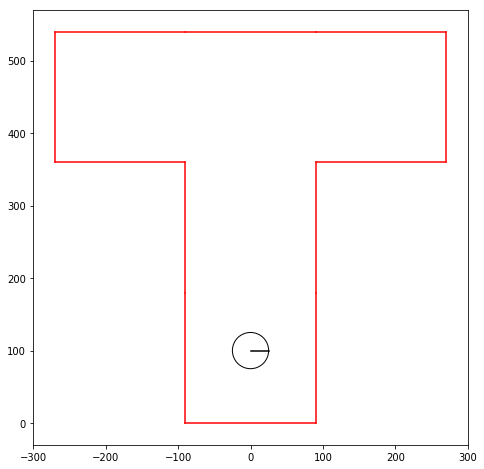

In [6]:
env.draw()